In [1]:
from keras.layers import Lambda, Input, Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Reshape, Conv2DTranspose
from keras.layers import MaxPooling3D, Conv3D, UpSampling3D, Conv3DTranspose
from keras.models import Model, Sequential
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.utils import to_categorical


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime as dt
import time
import glob
from IPython import display
import tensorflow as tf

import datetime as dt

Using TensorFlow backend.


In [2]:
def plot_autoencoder_outputs(encoder, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    n = 5
    plt.figure(figsize=(20, 9))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [3]:
def load_JESTER(path):
    """
    Imports the JESTER Dataset (12,2,100,176)
    """
    xs_train, ys_train, xs_test, ys_test = [], [], [], []

    classList=['Swiping_Down', 'Swiping_Left', 'Swiping_Right', 'Swiping_Up',
                      'Sliding_Two_Fingers_Down', 'Sliding_Two_Fingers_Left', 'Sliding_Two_Fingers_Right', 'Sliding_Two_Fingers_Up',
                      'Zooming_In_With_Two_Fingers', 'Zooming_Out_With_Two_Fingers']
    
    #classList=['Swiping_Left', 'Swiping_Right', 'Swiping_Up']    
    for class_index in classList:
        for (root, dirs, f) in os.walk('{0}/n_train_10/{1}'.format(path, str(class_index))):
            cnt=0
            print('Loading Train set')
            for file in f:
                cnt += 1
                if (cnt == 1001):
                    #print('Percent : {}%'.format(round((cnt / len(f)) * 100, 2)))
                    break
                
                X=np.load('{0}/n_train_10/{1}/{2}'.format(path, str(class_index), file))
                xs_train.append(X)
                ys_train.append(class_index)

        for (root, dirs, f) in os.walk('{0}/n_test/{1}'.format(path, str(class_index))):
            cnt=0
            print('Loading Test set')
            for file in f:
                cnt += 1
                if (cnt == 105):
                    print('Percent : {}%'.format(round((cnt / len(f)) * 100, 2)))
                    break
                        
                X = np.load('{0}/n_test/{1}/{2}'.format(path, str(class_index), file))
                xs_test.append(X)
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Yte = np.array(ys_test)
    
    return Xtr, Ytr, Xte, Yte

In [4]:
dataset_class_path = 'M:/LowPowerActionRecognition/CNN/JESTER/datasets/n_JESTURE_10'
x_train_1, y_train, x_test_1, y_test = load_JESTER(dataset_class_path)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

Loading Train set
Loading Test set
Percent : 20.83%
Loading Train set
Loading Test set
Percent : 21.88%
Loading Train set
Loading Test set
Percent : 22.15%
Loading Train set
Loading Test set
Percent : 21.3%
Loading Train set
Loading Test set
Percent : 20.59%
Loading Train set
Loading Test set
Percent : 20.79%
Loading Train set
Loading Test set
Percent : 20.87%
Loading Train set
Loading Test set
Percent : 20.87%
Loading Train set
Loading Test set
Percent : 20.55%
Loading Train set
Loading Test set
Percent : 31.44%
Training data shape:  (10000, 12, 2, 100, 176)
Training labels shape:  (10000,)
Test data shape:  (1040, 12, 2, 100, 176)
Test labels shape:  (1040,)


In [5]:
# to check memory size of the objects
import sys

In [6]:
print("Memory size of x_train_1 is " + str(sys.getsizeof(x_train_1)) + " bytes")
print("Memory size of x_test_1 is " + str(sys.getsizeof(x_test_1)) + " bytes")

Memory size of x_train_1 is 16896000160 bytes
Memory size of x_test_1 is 1757184160 bytes


In [7]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

x_train_2 = x_train_1.reshape(120000, 100, 176, 2)
x_train_1 = None

x_test_2 = x_test_1.reshape(12480, 100, 176, 2)
x_test_1 = None

print('Training data shape: ', x_train_2.shape)
print('Test data shape: ', x_test_2.shape)
print()
print("Memory size of x_train_1 is " + str(sys.getsizeof(x_train_1)) + " bytes")
print("Memory size of x_test_1 is " + str(sys.getsizeof(x_test_1)) + " bytes")
print("Memory size of x_train_2 is " + str(sys.getsizeof(x_train_2)) + " bytes")
print("Memory size of x_test_2 is " + str(sys.getsizeof(x_test_2)) + " bytes")

Training data shape:  (10000, 12, 2, 100, 176)
Training labels shape:  (10000,)
Test data shape:  (1040, 12, 2, 100, 176)
Test labels shape:  (1040,)
Training data shape:  (120000, 100, 176, 2)
Test data shape:  (12480, 100, 176, 2)

Memory size of x_train_1 is 16 bytes
Memory size of x_test_1 is 16 bytes
Memory size of x_train_2 is 144 bytes
Memory size of x_test_2 is 144 bytes


In [8]:
np.amin(x_train_2[0])

0

In [9]:
x_train_3 = np.zeros((120000, 104, 176, 2))
x_test_3 = np.zeros((12480, 104, 176, 2))
4992
for i in range (0, x_train_2.shape[0]):
    #print(i)
    x_train_3[i] = np.pad(x_train_2[i], ((2, 2), (0, 0), (0, 0)), 'edge')
    if (i < x_test_2.shape[0]):
        x_test_3[i] = np.pad(x_test_2[i], ((2, 2), (0, 0), (0, 0)), 'edge')


# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_3.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_3.shape)
print('Test labels shape: ', y_test.shape)


print()
print("Memory size of x_train_2 is " + str(sys.getsizeof(x_train_2)) + " bytes")
print("Memory size of x_test_2 is " + str(sys.getsizeof(x_test_2)) + " bytes")
print("Memory size of x_train_3 is " + str(sys.getsizeof(x_train_3)) + " bytes")
print("Memory size of x_test_3 is " + str(sys.getsizeof(x_test_3)) + " bytes")

Training data shape:  (120000, 104, 176, 2)
Training labels shape:  (10000,)
Test data shape:  (12480, 104, 176, 2)
Test labels shape:  (1040,)

Memory size of x_train_2 is 144 bytes
Memory size of x_test_2 is 144 bytes
Memory size of x_train_3 is 35143680144 bytes
Memory size of x_test_3 is 3654942864 bytes


In [10]:
x_train_2 = None
x_train_2 = None

In [11]:
# Flatten the dataset from range -1 to 1. Since the maxima and minima lies btw 15 so we divide it by 15.
x_train = (x_train_3.astype('float16'))
x_train_3 = None

x_test = (x_test_3.astype('float16'))
x_test_3 = None

print()
print("Memory size of x_train_3 is " + str(sys.getsizeof(x_train_3)) + " bytes")
print("Memory size of x_test_3 is " + str(sys.getsizeof(x_test_3)) + " bytes")
print("Memory size of x_train is " + str(sys.getsizeof(x_train)) + " bytes")
print("Memory size of x_test is " + str(sys.getsizeof(x_test)) + " bytes")



Memory size of x_train_3 is 16 bytes
Memory size of x_test_3 is 16 bytes
Memory size of x_train is 8785920144 bytes
Memory size of x_test is 913735824 bytes


In [12]:
print(x_train.shape)
print(x_test.shape)

(120000, 104, 176, 2)
(12480, 104, 176, 2)


In [13]:
np.amax(x_test)

4.0

In [14]:
# print('1')
# x_train[x_train!=0]+=10
# x_test[x_test!=0]+=10

# print('2')

# #Jesture range from 0-5
# #x_train = x_train/45
# x_train[:] = [x / 15 for x in x_train]
# #x_test = x_test/45
# x_test[:] = [x / 15 for x in x_test]



print("Normalisation stage:")

#Jesture range from 0-5
#x_train = x_train/45
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

x_train[:] = [x / 5 for x in x_train]
#x_test = x_test/45
x_test[:] = [x / 5 for x in x_test]

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Normalisation stage:
Start learning at 2019-04-02 02:30:57.867857
Stop learning 2019-04-02 02:33:00.617255
Elapsed learning 0:02:02.749398


In [15]:
np.amin(x_train[0])

0.0

In [30]:
epsilon_std=0.001

# z = z_mean + sqrt(var)*eps
#returns random value of z with the gives mean and variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma/2) * epsilon

In [31]:
#Defining number of kernels, strides and pooling sizes per layer

filters_1 = 32
filters_2 = 64
filters_3 = 128
#filters_1 = 32
#filters_2 = 64
#filters_3 = 128

# filters_4 = 64
# filters_5 = 128
# filters_6 = 256
# filters_7 = 512

stride_1 = (3, 3)
stride_2 = (3, 3)
stride_3 = (3, 3)
# stride_4 = (2, 2)
# stride_5 = (2, 2)
# stride_6 = (2, 2)
# stride_7 = (2, 2)

pool_1 = (2, 2)
pool_2 = (2, 2)
pool_3 = (2, 2)
# pool_4 = (2, 2)
# pool_5 = (2, 2)
# pool_6 = (2, 2)
# pool_7 = (2, 2)

In [32]:
#input_shape = (image_size, image_size, 1)
batch_size = 32 #fit_generator
#kernel_size = 3
#filters = 16
latent_dim = 70
epochs = 10

In [33]:
#Defining encoder

inputs = Input(shape = x_train[0].shape)

x = MaxPooling2D(pool_1, padding='same')(inputs)

x = Conv2D(filters_1, stride_1, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_2, padding='same')(x)

x = Conv2D(filters_2, stride_2, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_2, padding='same')(x)

x = Conv2D(filters_3, stride_3, activation='relu', padding='same')(x)
#x = MaxPooling3D(pool_3, padding='same')(x)

shape = K.int_shape(x)

x = Flatten()(x)

#Adding 1 hidden layer
#x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)


z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [34]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 104, 176, 2)  0                                            
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 52, 88, 2)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 52, 88, 32)   608         max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 26, 44, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (

In [35]:
#Defining Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#x = Dense(64, activation='relu')(latent_inputs)
x = Dense(128, activation='relu')(latent_inputs)
#x = Dense(512, activation='relu')(x)

#x = Dense(512, activation='relu')(latent_inputs)

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)


x = Conv2DTranspose(filters_2, stride_3, activation='relu', padding='same')(x)
x = UpSampling2D(pool_3)(x)

x = Conv2DTranspose(filters_1, stride_2, activation='relu', padding='same')(x)
x = UpSampling2D(pool_2)(x)

#x = Conv3DTranspose(filters_1, stride_1, activation='relu', padding='same')(x)
#x = UpSampling3D(pool_1)(x)

x = Conv2DTranspose(filters=2,
                          kernel_size=3,
                          activation='relu',
                          padding='same',
                          name='decoder_output')(x)
outputs = UpSampling2D(pool_1)(x)


In [36]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 70)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               9088      
_________________________________________________________________
dense_6 (Dense)              (None, 36608)             4722432   
_________________________________________________________________
reshape_2 (Reshape)          (None, 13, 22, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 13, 22, 64)        73792     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 26, 44, 64)        0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 26, 44, 32)        18464     
__________

In [37]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae_test=Model(inputs, outputs, name='vae_test')

In [38]:
from math import pow

In [39]:
# Compute VAE loss

# comparison = tf.math.greater(inputs, 0)
# new_out =  tf.where (comparison, outputs * 1000, outputs)
# x.assign(new_out)
# K.set_value(outputs, new_out)
# conditional_assignment_o = tf.assign(outputs, new_out)
# conditional_assignment_i = inputs.assign(inputs * 1000)
from keras.optimizers import Adam 

# xent_loss =  2312*binary_crossentropy(K.flatten(conditional_assignment_i), K.flatten(conditional_assignment_o))
xent_loss =  36608*binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
#xent_loss = 439296 * binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
#xent_loss = 422400*binary_crossentropy(inputs, outputs)

kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
# vae_loss =abs(K.mean(xent_loss + kl_loss))
vae_loss =abs(K.mean(xent_loss + 20*kl_loss))

opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
vae.add_loss(vae_loss)
vae.compile(optimizer=opt, metrics=['accuracy'])
vae_test.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
vae.summary()
vae_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 104, 176, 2)       0         
_________________________________________________________________
encoder (Model)              [(None, 70), (None, 70),  4796972   
_________________________________________________________________
decoder (Model)              (None, 104, 176, 2)       4824354   
Total params: 9,621,326
Trainable params: 9,621,326
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 104, 176, 2)       0         
_________________________________________________________________
encoder (Model)              [(None, 70), (None, 70),  4796972   
_________________________________________________________________


In [40]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time 

class_path = 'M:/LowPowerActionRecognition'
# Helper: Save the model.
checkpointer = ModelCheckpoint(
    filepath=os.path.join(class_path, 'autoencoder', 'JESTER', 'scripts2', 'checkpoints' \
    '.{epoch:03d}-{val_loss:.3f}.hdf5'),
    verbose=1,
    save_best_only=True)
# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join(class_path, 'autoencoder', 'JESTER', 'scripts2','tf_logs'))

# Helper: Stop when we stop learning.
early_stopper = EarlyStopping(patience=3)

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join(class_path, 'autoencoder', 'JESTER', 'scripts2', 'result_logs','training-' + \
    str(timestamp) + '.log'))

In [41]:
#STOP HERE
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

history=vae.fit(
        x=x_train, 
        shuffle = True,
        epochs = epochs, #10
        batch_size= 32,
        callbacks = [tb, early_stopper, csv_logger, checkpointer],
        validation_split = 0.1)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-04-02 02:59:53.365241
Train on 108000 samples, validate on 12000 samples
Epoch 1/10
108000/108000 [==============================] - 2852s 26ms/step - loss: 1183.7514 - val_loss: 714.6708

Epoch 00001: val_loss improved from inf to 714.67077, saving model to M:/LowPowerActionRecognition\autoencoder\JESTER\scripts2\checkpoints.001-714.671.hdf5
Epoch 2/10
108000/108000 [==============================] - 2842s 26ms/step - loss: 1095.1784 - val_loss: 689.1772

Epoch 00002: val_loss improved from 714.67077 to 689.17717, saving model to M:/LowPowerActionRecognition\autoencoder\JESTER\scripts2\checkpoints.002-689.177.hdf5
Epoch 3/10
108000/108000 [==============================] - 2851s 26ms/step - loss: 1076.4515 - val_loss: 709.0744

Epoch 00003: val_loss did not improve from 689.17717
Epoch 4/10
108000/108000 [==============================] - 2846s 26ms/step - loss: 1065.5870 - val_loss: 680.7769

Epoch 00004: val_loss improved from 689.17717 to 680.77693, saving mo

In [42]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
vae.save('CVAE_10class_6.h5')
encoder.save('encoder_10class_6.h5')
decoder.save('decoder_10class_6.h5')

ver1. all data is dark and erased. Not learning
ver2. some data is there but very wek and noisy. It can be because of the latent space being small or need to change the architecture.
ver3. Change dense value to 128 and keep latent space to 50, also beta =1. Result not bad but lots of noise and not clear for 2 fingers swipe. So want to increase dense to store more information as a test.
ver4. Increase the dense to 256, overfit like crazy!Solution can be decrease the learning rate or decrease the complexity of the model assuming using the same dataset. 
ver5. Change dense back to 128 and increase the latent space to 70. The idea is to reduce the complexity of the model and also increase the space the data can be store in. If this doesnt work then go back to ver3 and include beta and also reduce the learning rate to stop overfitting.
ver6. Goes back to ver3 but this time changes the reconstruction loss without multiplying and add beta=20. Adam learning rate changes to 0.0001 to make it learn slower. Also change the validation split to 0.1 to train more data.

In [ ]:
print(x_test.shape)

<Figure size 576x432 with 0 Axes>

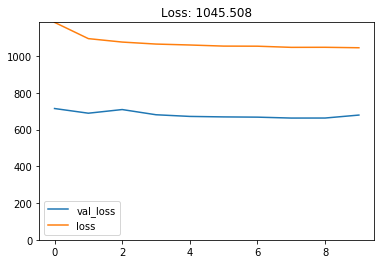

In [43]:
import pandas as pd
plot_loss(history)

In [ ]:
#np.save('encoded_10x_train.npy',x_train)
#np.save('encoded_10x_test.npy',x_test)

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)

In [ ]:
def plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=32)
    print(z_mean)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

In [ ]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [ ]:
def plot_autoencoder_outputs(encoder,k, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    #x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    #n = 5
    j=8000
    plt.figure(figsize=(20, 5))
    for i in range(k, n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[j].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[j].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
        j=j+1
    plt.show()

In [44]:
x_test_encoded = vae.predict(x_test, batch_size = batch_size)

In [ ]:
x_test_encoded = None

In [ ]:
print(x_test_encoded[10])

In [45]:
print(np.amax(x_test_encoded))
print(np.amax(x_test))

0.66887945
0.8


In [ ]:
print(x_test[10])

In [46]:
vae_test.set_weights(vae.get_weights())

#from random import shuffle

#shuffle(x_test)

score = vae_test.evaluate(x_test, x_test, verbose=1, batch_size=batch_size,steps=None)
#score = vae.evaluate(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12480/12480 [==============================] - 77s 6ms/step
Test loss: 0.029123979908987307
Test accuracy: 0.963631312816571


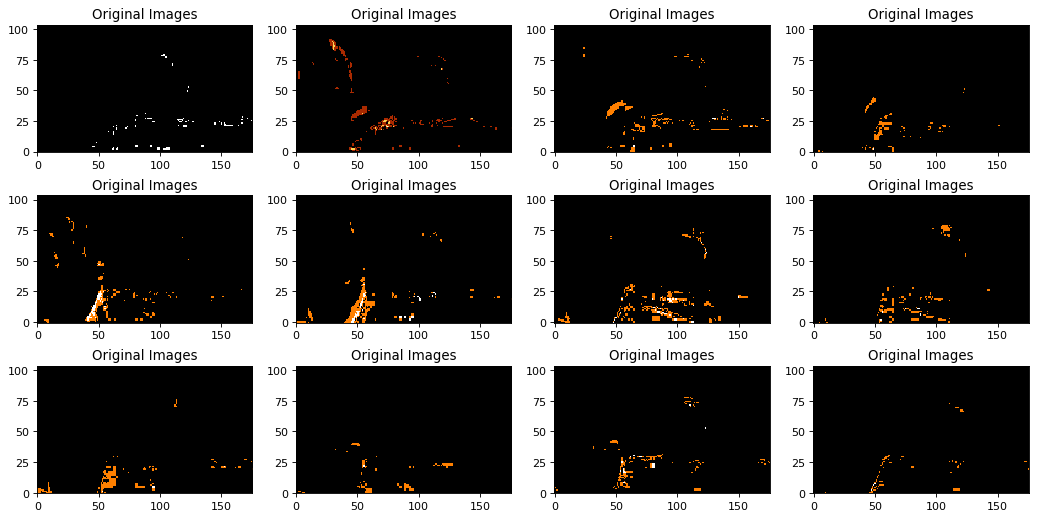

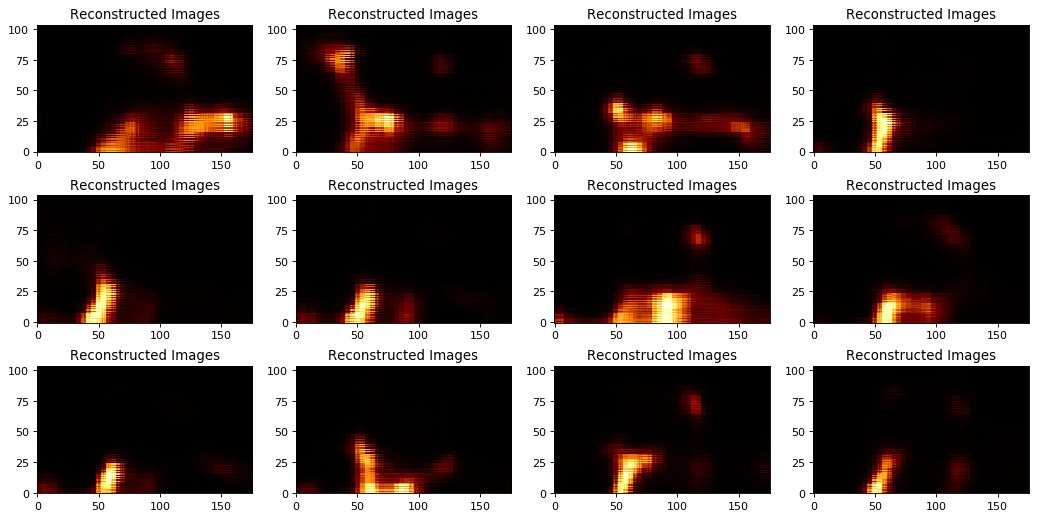

In [56]:
#Visualisation in 12 chunks
x_test_4 = (x_test.astype('float32'))

A0= x_test_4.reshape(1040,12,2,104,176)

id = 988

A = A0[id]
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3,4, i + 1)
    ax.set_title('Original Images')
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

    
#Visualisation in 12 chunks
A1= x_test_encoded.reshape(1040,12,2,104,176)
A = A1[id]
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    ax.set_title('Reconstructed Images')
    plt.imshow(A[i][0], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='afmhot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1)

In [ ]:
print(x_test_4.shape)

In [53]:
print(y_test[0])

Swiping_Down
